# CDCV Demo
In this notebook, we demonstrate the cross-distance covariance test for independence of time series.

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
from mgcpy.independence_tests.cdcv import CDCV

**Function to compute and print CDCV output values, given X and Y:**

In [2]:
def compute_cdcv(X, Y, max_lag):
    cdcv = CDCV(max_lag = max_lag, which_test = 'unbiased')
    cdcv_statistic, _ = cdcv.test_statistic(X, Y)
    p_value, _ = cdcv.p_value(X, Y)

    print("CDCV test statistic:", cdcv_statistic)
    print("P Value:", p_value)
    return cdcv_statistic, p_value

**Example: simulate data `X` and `Y` in the form of `n`-by-`p` and `n`-by-`q` matrices respectively, where `n` is the sample size.**

In [3]:
n = 25
p = 10
q = 5

X = np.random.normal(0.0, 1.0, n*p).reshape(n,p)
Y = np.random.normal(0.0, 1.0, n*q).reshape(n,q)

max_lag = 2 # 'M' parameter for CDCV test.

CDCV_statistic, p_value = compute_cdcv(X, Y, max_lag)

CDCV test statistic: 3.59486142036074
P Value: 0.131


In the following cells, we simulate different time series processes and estimate the power of the test at varying choices of sample size. Additionally, we compare against the Ljung-Box test of correlation.

**Function to simulate time series.**

In [4]:
def indep_ar1(n):
    # X_t and Y_t are univarite AR(1) with phi = 0.5.
    
    # Innovations.
    epsilons = np.random.normal(0.0, 1.0, n)
    etas = np.random.normal(0.0, 1.0, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = 0.5*X[t-1] + epsilons[t]
        Y[t] = 0.5*Y[t-1] + etas[t]
        
    return X, Y

In [5]:
def lin_dep_ar1(n):
    # X_t and Y_t are together a bivarite AR(1) with Phi = [0 0.5; 0.5 0].
    
    # Innovations.
    epsilons = np.random.normal(0.0, 1.0, n)
    etas = np.random.normal(0.0, 1.0, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = 0.5*Y[t-1] + epsilons[t]
        Y[t] = 0.5*X[t-1] + etas[t]
        
    return X, Y

In [6]:
def nonlin_dep_ma1(n):
    # X_t and Y_t are together a bivarite NMA(1).
    
    # Innovations.
    epsilons = np.random.normal(0.0, 1.0, n)
    etas = np.random.normal(0.0, 1.0, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # MA(1) process.
    for t in range(1,n):
        X[t] = epsilons[t]*epsilons[t-1]*etas[t-1]
        Y[t] = etas[t]*etas[t-1]*epsilons[t-1]
        
    return X, Y

In [7]:
def ljung_box(X, Y, max_lag, alpha):
    n = len(X)
    test_statistic = 0
    for j in range(1,max_lag+1):
            lead_X = X[j:n]
            lag_Y = Y[0:(n-j)]
            test_statistic = test_statistic + ((np.corrcoef(lead_X,lag_Y)[1,0])**2 / (n-j))

            lag_X = X[0:(n-j)]
            lead_Y = Y[j:n]
            test_statistic += ((np.corrcoef(lead_X,lag_Y)[1,0])**2 / (n-j))
    test_statistic *= (n*(n+2))
    
    critical_value = chi2.ppf(1-alpha, df = 2*max_lag)
    return(test_statistic >= critical_value)

In [8]:
def power_curve(sample_sizes, powers_cdcv, powers_lb, alpha, title):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.xlabel("n")
    plt.ylabel("Rejection Probability")
    plt.ylim((-0.05, 1.05)) 
    
    err_cdcv = 1.96*np.sqrt(np.divide(np.multiply(powers_cdcv, 1-powers_cdcv), sample_sizes))
    err_lb = 1.96*np.sqrt(np.divide(np.multiply(powers_lb, 1-powers_lb), sample_sizes))
    plt.errorbar(x = sample_sizes, y = powers_cdcv, yerr = err_cdcv, linestyle = '-', color = 'blue')
    plt.errorbar(x = sample_sizes, y = powers_lb, yerr = err_lb, color = 'red', linestyle = ':')
    ax.legend(['CDCV', 'LB'], loc = 'upper left')
    
    ax.axhline(y=alpha, color = 'black', linestyle = '--')
    ax.axhline(y=1, color = 'black', linestyle = '--')
    plt.show()

**Compute power curves of the test on each process.**

Estimating power at sample size:  10........................................
Estimating power at sample size:  20........................................
Estimating power at sample size:  30........................................
Estimating power at sample size:  40........................................
Estimating power at sample size:  50........................................
Estimating power at sample size:  60........................................
Estimating power at sample size:  70........................................
Estimating power at sample size:  80........................................
Estimating power at sample size:  90........................................
Estimating power at sample size:  100........................................


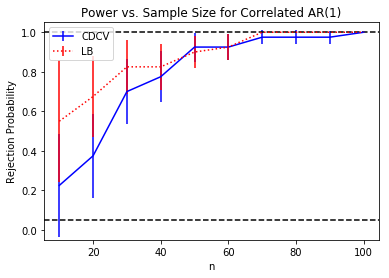

In [10]:
# Experimental parameters.
sample_sizes = range(10,110,10)
num_sims = 10
num_bootstrap = 10
alpha = 0.05
maxlag = 2

cdcv = CDCV(max_lag = maxlag)
powers_cdcv = np.zeros(num_sims*len(sample_sizes)).reshape(len(sample_sizes), num_sims)
powers_lb = np.zeros(num_sims*len(sample_sizes)).reshape(len(sample_sizes), num_sims)

sims      = [indep_ar1, 
             lin_dep_ar1, 
             nonlin_dep_ma1]
sim_names = ["Power vs. Sample Size for Independent AR(1)", 
             "Power vs. Sample Size for Correlated AR(1)", 
             "Power vs. Sample Size for Nonlin. Dependent MA(1)"]

for s in range(len(sims)):
    sim_type = sims[s]
    for i in range(len(sample_sizes)):
        rejects_cdcv = 0.0
        rejects_lb   = 0.0
        n = sample_sizes[i]
        print("Estimating power at sample size: ", str(n), end = "")
        for t in range(num_sims):
            print('.', end='')
            X, Y = sim_type(n)
            p_value, _ = cdcv.p_value(X, Y, replication_factor = num_bootstrap)
            if p_value < alpha:
                rejects_cdcv += 1
            if ljung_box(X, Y, maxlag, alpha):
                rejects_lb += 1
        
        powers_cdcv[i] = rejects_cdcv/num_sims
        powers_lb[i] = rejects_lb/num_sims
        print("")
    power_curve(sample_sizes, powers_cdcv, powers_lb, alpha, sim_names[s])